In [1]:
import tensorflow as tf
# test if cuda is available
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

False
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# if the train and validation folders does not exist, run the following commands
# check is train and validation folders exist
# if not, create them
import os
if not (os.path.exists('train') and os.path.exists('validation')):
    import zipfile
    base_dir = os.curdir
    # Unzip the archive
    local_zip = os.path.join(base_dir, 'satellitehurricaneimages.zip')
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall()

    zip_ref.close()

In [3]:
import os

base_dir = os.path.abspath('')

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['.git', '.gitignore', '.idea', '.ipynb_checkpoints', '.venv', 'damage_no_damage.png', 'huricane-damage-torch.ipynb', 'LICENSE.txt', 'my_model.h5', 'notebook.ipynb', 'README.md', 'requirement.txt', 'satellitehurricaneimages.zip', 'solution.py', 'tensorflow_gpu_test.py', 'train', 'unzip.py', 'validation']

Contents of train directory:
['.DS_Store', 'damage', 'no_damage']

Contents of validation directory:
['.DS_Store', 'damage', 'no_damage']


In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training damage/no damage pictures
train_damage_dir = os.path.join(train_dir, 'damage')
train_no_damage_dir = os.path.join(train_dir, 'no_damage')

# Directory with validation damage/no damage pictures
validation_damage_dir = os.path.join(validation_dir, 'damage')
validation_no_damage_dir = os.path.join(validation_dir, 'no_damage')

In [5]:
os.path.abspath('')


'c:\\Users\\darcy\\PycharmProjects\\CNN-for-Hurricane-Damage-Classification'

In [6]:
train_damage_fnames = os.listdir( train_damage_dir )
train_no_damage_fnames = os.listdir( train_no_damage_dir )

print(train_damage_fnames[:10])
print(train_no_damage_fnames[:10])

['-93.55964_30.895018.jpeg', '-93.573763_30.693981.jpeg', '-93.578271_30.779923999999998.jpeg', '-93.59011_30.695412.jpeg', '-93.59030899999999_30.694764000000003.jpeg', '-93.590598_30.694956.jpeg', '-93.597636_30.674362.jpeg', '-93.599611_30.668616999999998.jpeg', '-93.601916_30.793329999999997.jpeg', '-93.602625_30.02372.jpeg']
['-95.061275_29.831535.jpeg', '-95.061412_29.826522999999998.jpeg', '-95.061825_29.828608000000003.jpeg', '-95.061908_29.828245000000003.jpeg', '-95.061936_29.828088.jpeg', '-95.062117_29.828828.jpeg', '-95.06212_29.829257000000002.jpeg', '-95.062166_29.828609999999998.jpeg', '-95.062166_29.82945.jpeg', '-95.06218199999999_29.82831.jpeg']


In [7]:
print('total training damage images :', len(os.listdir(      train_damage_dir ) ))
print('total training no_damage images :', len(os.listdir(      train_no_damage_dir ) ))

print('total validation damage images :', len(os.listdir( validation_damage_dir ) ))
print('total validation no_damage images :', len(os.listdir( validation_no_damage_dir ) ))

total training damage images : 5000
total training no_damage images : 5000
total validation damage images : 1000
total validation no_damage images : 1000


In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

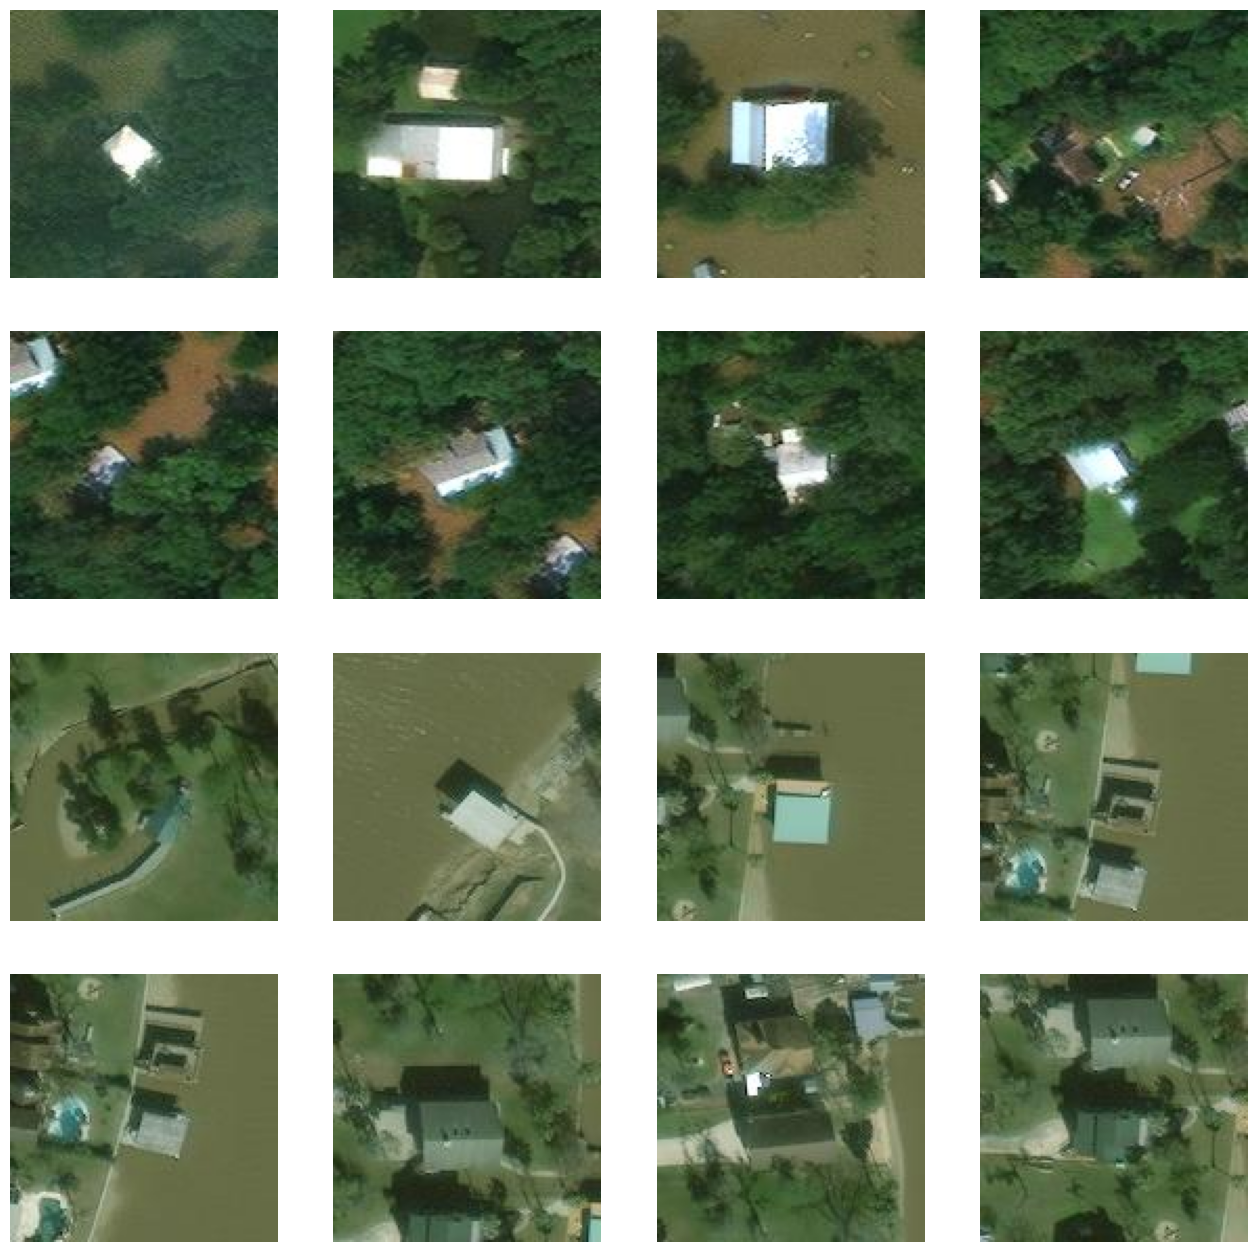

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_damage_pix = [os.path.join(train_damage_dir, fname) 
                for fname in train_damage_fnames[ pic_index-8:pic_index] 
               ]

next_no_damage_pix = [os.path.join(train_no_damage_dir, fname) 
                for fname in train_no_damage_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_damage_pix+next_no_damage_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()
# save the image
fig.savefig('damage_no_damage.png')

In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('damages') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:

history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
500/500 - 10s - loss: 0.4378 - accuracy: 0.8045 - val_loss: 0.2618 - val_accuracy: 0.8930 - 10s/epoch - 20ms/step
Epoch 2/15
500/500 - 7s - loss: 0.2226 - accuracy: 0.9076 - val_loss: 0.1598 - val_accuracy: 0.9435 - 7s/epoch - 14ms/step
Epoch 3/15
500/500 - 7s - loss: 0.1770 - accuracy: 0.9319 - val_loss: 0.1774 - val_accuracy: 0.9430 - 7s/epoch - 14ms/step
Epoch 4/15
500/500 - 7s - loss: 0.1494 - accuracy: 0.9445 - val_loss: 0.1511 - val_accuracy: 0.9450 - 7s/epoch - 14ms/step
Epoch 5/15
500/500 - 7s - loss: 0.1390 - accuracy: 0.9503 - val_loss: 0.4745 - val_accuracy: 0.8000 - 7s/epoch - 14ms/step
Epoch 6/15
500/500 - 7s - loss: 0.1236 - accuracy: 0.9533 - val_loss: 0.1375 - val_accuracy: 0.9560 - 7s/epoch - 14ms/step
Epoch 7/15
500/500 - 7s - loss: 0.1106 - accuracy: 0.9599 - val_loss: 0.1402 - val_accuracy: 0.9485 - 7s/epoch - 14ms/step
Epoch 8/15
500/500 - 7s - loss: 0.0960 - accuracy: 0.9695 - val_loss: 0.1611 - val_accuracy: 0.9445 - 7s/epoch - 14ms/step
Epoch 9/15
500

In [14]:
# save the model
model.save('damage_no_damage.h5')

In [15]:
'''
train_damage_fnames = os.listdir( train_damage_dir )
train_no_damage_fnames = os.listdir( train_no_damage_dir )
'''
# Prepare a random input image from the training set.
damage_img_files = [os.path.join(train_damage_dir, f) for f in train_damage_fnames]
no_damage_img_files = [os.path.join(train_no_damage_dir, f) for f in train_no_damage_fnames]

In [16]:
def visuzlize_layers(model, img_dir):
  import numpy as np
  import random
  from tensorflow.keras.utils import img_to_array, load_img

  # Define a new Model that will take an image as input, and will output
  # intermediate representations for all layers in the previous model
  successive_outputs = [layer.output for layer in model.layers]
  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

  img_path = random.choice(img_dir)

  img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
  x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
  x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

  # Scale by 1/255
  x /= 255.0

  # Run the image through the network, thus obtaining all
  # intermediate representations for this image.
  successive_feature_maps = visualization_model.predict(x)

  # These are the names of the layers, so you can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]

  # Display the representations
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
    if len(feature_map.shape) == 4:
      
      #-------------------------------------------
      # Just do this for the conv / maxpool layers, not the fully-connected layers
      #-------------------------------------------
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      
      # Tile the images in this matrix
      display_grid = np.zeros((size, size * n_features))
      
      #-------------------------------------------------
      # Postprocess the feature to be visually palatable
      #-------------------------------------------------
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

      #-----------------
      # Display the grid
      #-----------------
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
  return img_path

1/1 [==============================] - 0s 387ms/step


C:\Users\darcy\AppData\Local\Temp\ipykernel_41376\924156263.py:47: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
C:\Users\darcy\AppData\Local\Temp\ipykernel_41376\924156263.py:50: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


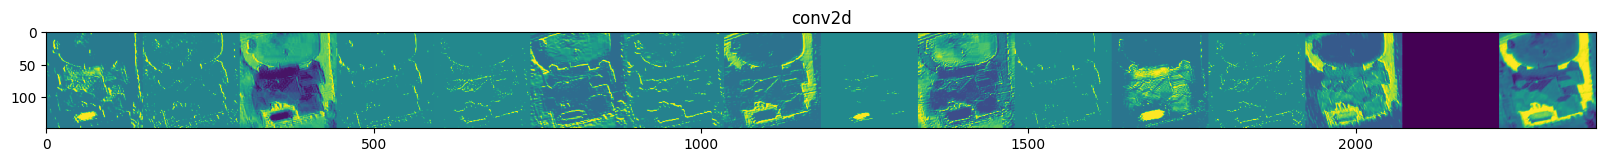

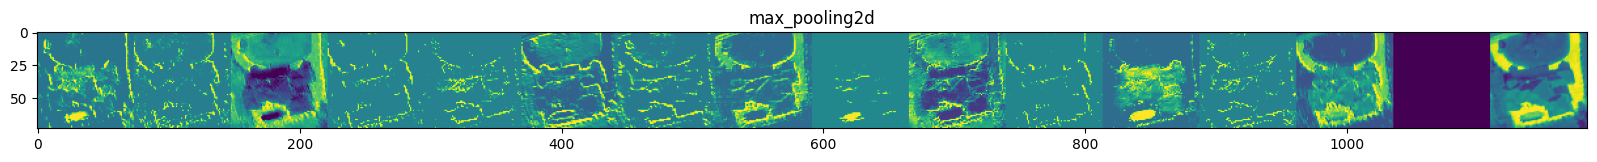

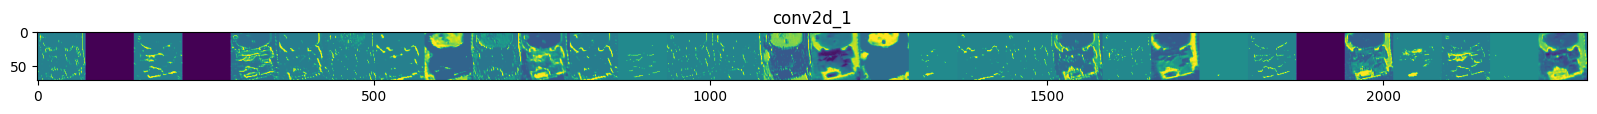

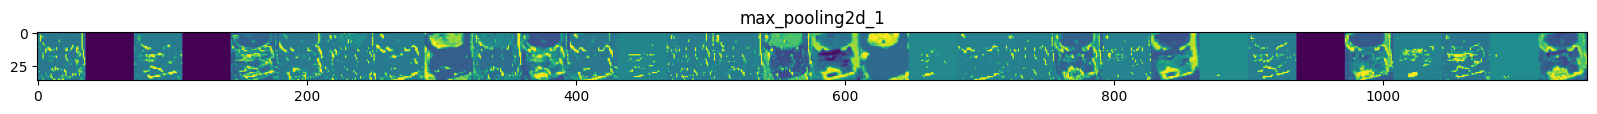

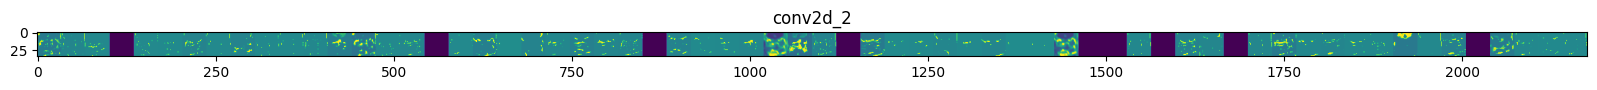

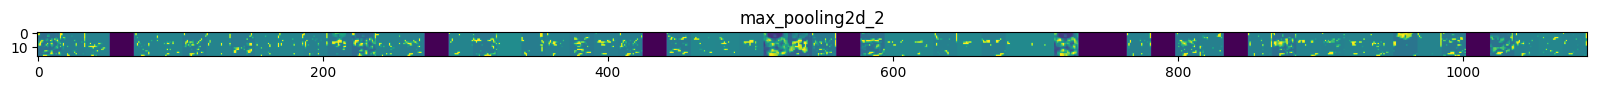

In [17]:
f = visuzlize_layers(model, no_damage_img_files)

1/1 [==============================] - 0s 97ms/step


C:\Users\darcy\AppData\Local\Temp\ipykernel_41376\924156263.py:47: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
C:\Users\darcy\AppData\Local\Temp\ipykernel_41376\924156263.py:50: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


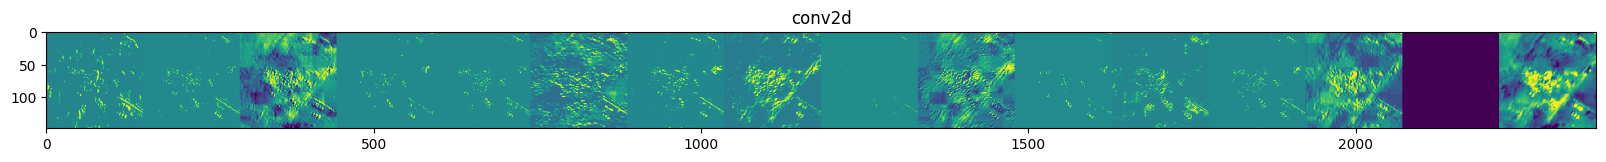

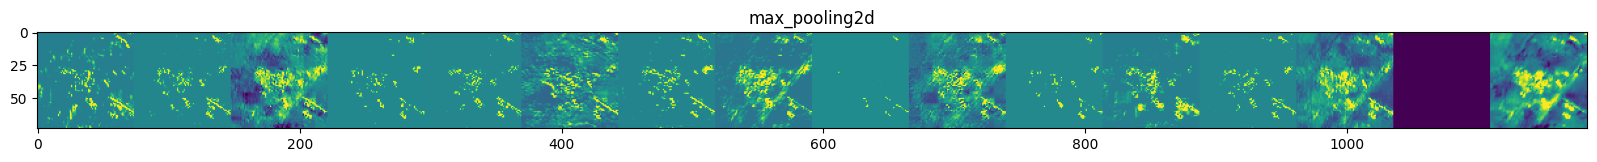

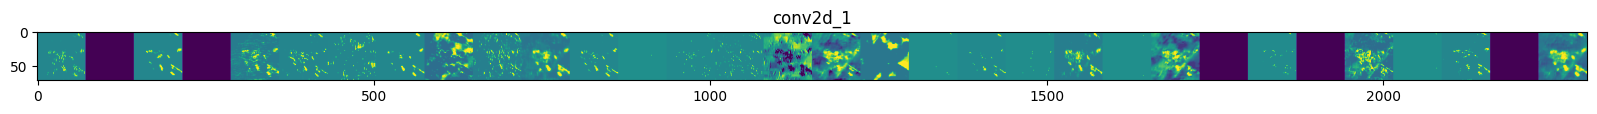

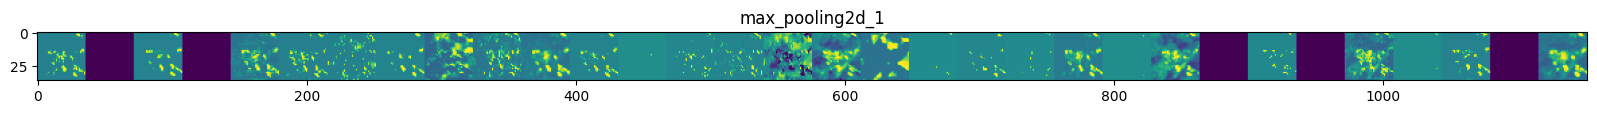

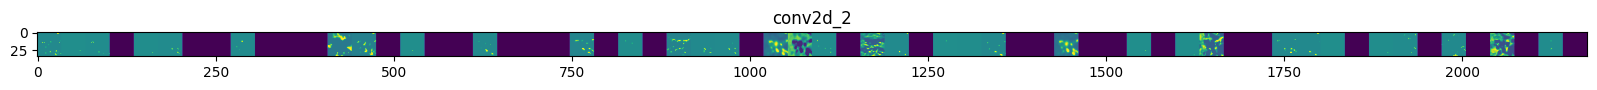

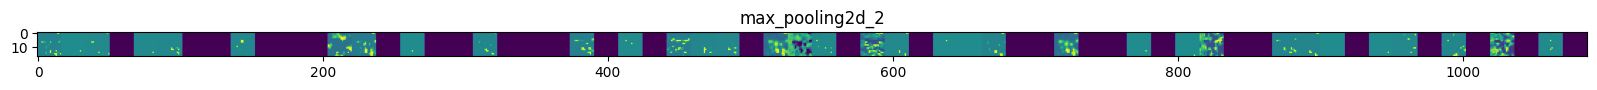

In [18]:
f = visuzlize_layers(model, damage_img_files)